In [8]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor
import joblib

# CSV 파일 로드
df = pd.read_csv("ingredients.csv")
ingredient_features = pd.read_csv("CocktailIngredients.csv", index_col=0)
drink_df = pd.read_csv("drinks.csv")  # 칵테일 이름과 점수 정보를 담은 파일

# 재료명 매핑 사전 (원본 이름 -> 특성 데이터프레임의 인덱스)
ingredient_mapping = {
    'rum': 'rum',
    'almond liqueur': 'almond_liqueur',
    'orange juice': 'orange_juice',
    'lemon': 'lemon_garnish',
    'lemon juice': 'lemon_juice',
    'gin': 'gin',
    'orange liqueur': 'orange_liqueur',
    'simple syrup': 'simple_syrup',
    'bitters': 'bitters',
    'orange': 'orange_garnish',
    'cherry': 'cherry_garnish',
    'maraschino cherry': 'cherry_garnish',
    'sweet vermouth': 'sweet_vermouth',
    'lime juice': 'lime_juice',
    'soda': 'soda',
    'milk': 'milk',
    'mint': 'mint_leaves',
    'whiskey': 'whiskey',
    'vodka': 'vodka',
    'tequila': 'tequila',
    'water': 'water',
    'vermouth': 'sweet_vermouth',  # 기본값으로 sweet_vermouth 사용
    'dry vermouth': 'dry_vermouth',
    'brandy': 'brandy',
    'lime': 'lime_garnish',
    'pot wine': 'pot_wine',
    'cranberry juice': 'cranberry_juice',
    # 필요한 매핑 추가
}

# 재료량을 ml로 변환하는 함수
def convert_to_ml(amount_str):
    if not amount_str or pd.isna(amount_str) or amount_str == "":
        return 5  # 양이 명시되지 않은 경우 기본값
    
    # "Fill", "Top", "Filled" 등의 표현이 있으면 큰 양으로 처리
    if re.search(r'fill|top|full', str(amount_str).lower()):
        return 60  # filling은 60ml로 가정
    
    # 숫자 추출 (분수 포함)
    amount_match = re.search(r'(\d+(?:\.\d+)?|\d+/\d+)', str(amount_str))
    if not amount_match:
        return 5  # 숫자가 없는 경우 기본값
    
    amount_val = amount_match.group(1)
    # 분수 처리 (1/2 -> 0.5)
    if '/' in amount_val:
        num, denom = amount_val.split('/')
        amount_num = float(num) / float(denom)
    else:
        amount_num = float(amount_val)
    
    # 단위에 따른 변환
    amount_str_lower = str(amount_str).lower()
    if 'oz' in amount_str_lower:
        return amount_num * 30  # 1 oz = 30 ml
    elif 'dash' in amount_str_lower:
        return amount_num * 5   # 1 dash = 5 ml
    elif 'shot' in amount_str_lower:
        return amount_num * 45  # 1 shot = 45 ml
    elif 'jigger' in amount_str_lower:
        return amount_num * 45  # 1 jigger = 45 ml
    elif 'tsp' in amount_str_lower:
        return amount_num * 5   # 1 tsp = 5 ml
    elif 'tblsp' in amount_str_lower or 'tbsp' in amount_str_lower:
        return amount_num * 15  # 1 tablespoon = 15 ml
    elif 'part' in amount_str_lower:
        return amount_num * 30  # 1 part = 30 ml (상대적 비율)
    elif 'cl' in amount_str_lower:
        return amount_num * 10  # 1 cl = 10 ml
    elif 'ml' in amount_str_lower:
        return amount_num  # 이미 ml 단위일 경우 그대로 사용
    else:
        return amount_num * 30  # 기본값으로 30ml 가정

# 재료량과 재료이름 분리하기 위한 개선된 함수
def extract_amount_and_ingredient(ingredient_text):
    if pd.isna(ingredient_text):
        return "", ""
    
    # "Juice of 1/2 Lemon"과 같은 특수 케이스 처리
    juice_match = re.match(r'juice\s+of\s+(.+?)\s+(.+)', ingredient_text.lower())
    if juice_match:
        amount = juice_match.group(1)
        ingredient = juice_match.group(2)
        # "juice of 1/2 lemon" -> 양: "1/2", 재료: "lemon juice"
        if ingredient.lower() in ['lemon', 'lime', 'orange']:
            return amount, f"{ingredient} juice"
        return amount, ingredient
    
    # 일반적인 패턴: "1 oz Rum", "1/2 shot Gin" 등
    pattern = r'^((?:[\d./]+)?\s*(?:oz|shot|tsp|tblsp|tbsp|dash|jigger|part|fill|cl|ml|top|can)?\s*(?:of)?)\s*(.+)$'
    match = re.match(pattern, ingredient_text.strip(), re.IGNORECASE)
    
    if match:
        amount = match.group(1).strip()
        ingredient = match.group(2).strip()
        # 양이 비어있으면 빈 문자열 반환
        if amount == "":
            return "", ingredient
        return amount, ingredient
    else:
        # 매칭되지 않으면 전체를 재료명으로 간주
        return "", ingredient_text.strip()

# 특별 취급 재료 목록
special_ingredients = [
    'simple_syrup', 'milk', 'mint_leaves', 'orange_garnish', 'lime_garnish', 
    'cherry_garnish', 'mint_garnish', 'olive_garnish', 'ice', 'water', 'soda', 'salt'
]

# 특별 재료의 기본 양 설정
special_amounts = {
    'simple_syrup': 15,  # 15ml
    'milk': 30,          # 30ml
    'mint_leaves': 5,    # 가니쉬 용도로 5ml 가정
    'orange_garnish': 5,
    'lime_garnish': 5,
    'cherry_garnish': 5,
    'mint_garnish': 5,
    'olive_garnish': 5,
    'ice': 100,          # 얼음은 부피가 크지만 실제 액체 함량은 적음
    'water': 30,
    'soda': 60,
    'salt': 2
}

# 재료를 표준화하는 함수 (매핑 사전 사용)
def standardize_ingredient(ingredient):
    if pd.isna(ingredient):
        return ""
    
    # 소문자로 변환
    ingredient_lower = ingredient.lower()
    
    # 매핑 사전에서 찾기
    for key, value in ingredient_mapping.items():
        if key in ingredient_lower:
            return value
    
    # 매핑이 없으면 공백을 언더스코어로 변경
    return ingredient_lower.replace(' ', '_')

# 새로운 칼럼 추가
df[['amount_str', 'ingredient']] = df['ingredient_name'].apply(
    lambda x: pd.Series(extract_amount_and_ingredient(x))
)

# 재료 표준화 적용
df['std_ingredient'] = df['ingredient'].apply(standardize_ingredient)

# 재료량을 ml로 변환
df['amount_ml'] = df['amount_str'].apply(convert_to_ml)

# 특별 재료의 경우 기본 양 적용
for i, row in df.iterrows():
    if row['std_ingredient'] in special_ingredients:
        # 이미 양이 지정되어 있으면 그대로 사용, 아니면 기본값 사용
        if pd.isna(row['amount_str']) or row['amount_str'] == "":
            df.at[i, 'amount_ml'] = special_amounts[row['std_ingredient']]

# 처리된 데이터 확인
print("처리된 데이터 샘플:")
print(df[['ingredient_name', 'amount_str', 'ingredient', 'std_ingredient', 'amount_ml']].head(10))

# ID별로 그룹화하여 레시피 딕셔너리 생성
recipes = {}
for id_val, group in df.groupby('id'):
    recipes[id_val] = {}
    for _, row in group.iterrows():
        std_ingredient = row['std_ingredient']
        if std_ingredient and std_ingredient != "":  # 빈 문자열 무시
            amount_ml = row['amount_ml']
            recipes[id_val][std_ingredient] = amount_ml

# 레시피 확인
for recipe_id, ingredients in list(recipes.items())[:3]:  # 처음 3개 레시피만 출력
    print(f"\n레시피 ID: {recipe_id}")
    for ingredient, amount in ingredients.items():
        print(f"  - {amount} ml {ingredient}")

# 레시피를 특성 벡터로 변환하는 함수
def recipe_to_vector(recipe, ingredient_features):
    categories = ingredient_features.columns.tolist()
    cocktail_vector = np.zeros(len(categories))  # 벡터 초기화
    
    total_amount = 0
    missing_ingredients = []

    for ingredient, amount_ml in recipe.items():
        if ingredient in ingredient_features.index:  # 재료가 특성 데이터프레임에 있는지 확인
            cocktail_vector += ingredient_features.loc[ingredient].values * amount_ml
            total_amount += amount_ml
        else:
            missing_ingredients.append(ingredient)
    
    # 누락된 재료 보고
    if missing_ingredients:
        print(f"경고: 다음 재료가 특성 데이터프레임에 없습니다: {', '.join(missing_ingredients)}")
    
    # 총량으로 나누어 정규화
    if total_amount > 0:
        cocktail_vector /= total_amount
    else:
        print("경고: 총량이 0입니다. 벡터 값이 0으로 남을 수 있습니다.")
    
    return cocktail_vector

# 'drink.csv'에서 칵테일 특징 점수 로딩
drink_features = ['alcohol', 'sweet', 'sour', 'bitter', 'body', 'herbal', 'coffee', 'fruit', 'citrus', 'creamy']

# 훈련 데이터 생성
X = []
y = []
valid_recipes = []

# drink_df의 구조 확인
print("\n=== drinks.csv 구조 확인 ===")
print(f"drink_df 열: {drink_df.columns.tolist()}")
print(f"drink_df 샘플:\n{drink_df.head()}")

# 인덱스 설정 전에 열 확인
if 'name' not in drink_df.columns:
    print("오류: 'drinks.csv'에 'name' 열이 없습니다.")
    # 첫 번째 열을 인덱스로 사용하려면:
    first_column = drink_df.columns[0]
    print(f"첫 번째 열({first_column})을 인덱스로 사용합니다.")
    drink_df.set_index(first_column, inplace=True)
else:
    drink_df.set_index('name', inplace=True)

# 인덱스 설정 후 확인
print(f"인덱스 설정 후 drink_df 샘플:\n{drink_df.head()}")

# drink_df에서 필요한 특성이 있는지 확인
missing_features = [feature for feature in drink_features if feature not in drink_df.columns]
if missing_features:
    print(f"오류: drinks.csv에 다음 특성이 없습니다: {', '.join(missing_features)}")
    print(f"사용 가능한 열: {drink_df.columns.tolist()}")

# 훈련 데이터 준비
for recipe_id, recipe in recipes.items():
    # 빈 레시피 건너뛰기
    if not recipe:
        continue
        
    vector = recipe_to_vector(recipe, ingredient_features)
    
    # 모든 값이 0인 벡터 건너뛰기
    if np.sum(vector) > 0:
        X.append(vector)
        
        # drink.csv에서 해당 레시피의 특성 점수 추출
        if recipe_id in drink_df['id'].values:  # id 컬럼에서 recipe_id를 찾음
            try:
                feature_values = drink_df[drink_df['id'] == recipe_id][drink_features].values[0]
                y.append(feature_values)
                valid_recipes.append(recipe_id)
                print(f"레시피 ID {recipe_id} 추가됨: {feature_values}")
            except KeyError as e:
                print(f"KeyError: {recipe_id}의 특성 점수를 추출하는 중 오류 발생: {e}")
                print(f"현재 인덱스: {drink_df['id'][:10]}...")  # 처음 10개 id만 출력
        else:
            print(f"레시피 ID {recipe_id}를 drinks.csv에서 찾을 수 없음 ({recipe_id})")


# 훈련 데이터 확인
X = np.array(X)
y = np.array(y)

print(f"\n훈련 데이터 크기: {X.shape}, {y.shape}")

if len(X) == 0 or len(y) == 0:
    print("오류: 훈련 데이터가 없습니다. 데이터 불러오기와 전처리를 확인하세요.")
else:
    # 훈련 데이터 샘플 확인
    print("\n훈련 데이터 샘플:")
    for i in range(min(10, len(X))):
        print(f"X[{i}]: {X[i]}")
        print(f"y[{i}]: {y[i]}")
        print("---")

    # 모델 훈련
    print("\n모델 훈련 시작...")
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    print("모델 훈련 완료")

    # 특성 중요도 확인
    print("\n특성 중요도:")
    feature_importances = model.feature_importances_
    for i, importance in enumerate(feature_importances):
        print(f"특성 {i}: {importance}")

    # 모델 저장
    joblib.dump(model, 'cocktail_quality_predictor.pkl')
    print("모델 저장됨: cocktail_quality_predictor.pkl")

    # 칵테일 예측을 위한 클래스 정의
    class CocktailPredictor:
        def __init__(self, model, ingredient_features):
            self.model = model
            self.ingredient_features = ingredient_features
            self.feature_names = ['alcohol', 'sweet', 'sour', 'bitter', 'body', 'herbal', 'coffee', 'fruit', 'citrus', 'creamy']
            
            # 매핑과 함수들도 클래스 내부에 포함
            self.ingredient_mapping = ingredient_mapping
            self.special_amounts = special_amounts
            self.special_ingredients = special_ingredients

        def parse_ingredient_input(self, ingredient_str):
            """사용자 입력 문자열에서 재료와 양 추출"""
            amount_str, ingredient = extract_amount_and_ingredient(ingredient_str)
            std_ingredient = standardize_ingredient(ingredient)
            amount_ml = convert_to_ml(amount_str)
            
            # 특별 재료의 경우 기본 양 적용
            if std_ingredient in self.special_ingredients and (not amount_str or amount_str == ""):
                amount_ml = self.special_amounts[std_ingredient]
                
            return std_ingredient, amount_ml

        def parse_recipe_input(self, recipe_str):
            """여러 재료를 포함한 문자열 입력을 파싱하여 레시피 딕셔너리 생성"""
            recipe = {}
            
            # 줄바꿈이나 쉼표로 재료 분리
            if '\n' in recipe_str:
                ingredients_list = recipe_str.strip().split('\n')
            else:
                ingredients_list = recipe_str.strip().split(',')
            
            for ingredient_str in ingredients_list:
                ingredient_str = ingredient_str.strip()
                if ingredient_str:
                    std_ingredient, amount_ml = self.parse_ingredient_input(ingredient_str)
                    if std_ingredient and std_ingredient != "":
                        recipe[std_ingredient] = amount_ml
            
            return recipe

        def predict_cocktail(self, recipe_input):
            """레시피 입력을 받아 칵테일 특성 점수 예측"""
            # 입력이 문자열이면 파싱, 딕셔너리면 그대로 사용
            if isinstance(recipe_input, str):
                recipe = self.parse_recipe_input(recipe_input)
            else:
                recipe = recipe_input
                
            # 레시피가 비어있는지 확인
            if not recipe:
                return "오류: 유효한 재료가 입력되지 않았습니다."
            
            # 레시피 정보 출력
            print("\n입력된 레시피:")
            for ingredient, amount in recipe.items():
                print(f"  - {amount} ml {ingredient}")
            
            # 레시피를 벡터로 변환
            vector = recipe_to_vector(recipe, self.ingredient_features)
            
            # 벡터 확인
            print(f"\n변환된 벡터: {vector}")
            
            # 예측
            try:
                prediction = self.model.predict([vector])[0]
                print(f"원시 예측 값: {prediction}")
            except Exception as e:
                print(f"예측 중 오류 발생: {e}")
                return "예측 중 오류가 발생했습니다."
            
            # 결과를 딕셔너리로 변환
            result = {}
            for i, feature_name in enumerate(self.feature_names):
                # 모든 점수를 0-10 사이로 조정 (필요한 경우)
                score = min(max(prediction[i], 0), 10)
                result[feature_name] = round(score, 1)
            
            return result

    # CocktailIngredients.csv 구조 확인
    print("\n=== CocktailIngredients.csv 구조 확인 ===")
    print(f"ingredient_features 인덱스 샘플: {ingredient_features.index[:10].tolist()}")
    print(f"ingredient_features 열: {ingredient_features.columns.tolist()}")
    print(f"ingredient_features 데이터 샘플:\n{ingredient_features.head()}")

    # 샘플 데이터로 모델 테스트
    print("\n=== 모델 테스트: 샘플 칵테일 예측 ===")

    # 모델 인스턴스 생성
    predictor = CocktailPredictor(model, ingredient_features)

    # 샘플 레시피 1: 진 마티니
    gin_martini = """
    1.5 oz gin
    1 dash bitters
    orange garnish
    cherry garnish
    """

    # 샘플 레시피 2: 마가리타
    margarita = """
    1 oz orange liqueur
    1 oz brandy
    lime garnish
    """

    # 샘플 레시피 3: 모히토
    mojito = """
    1.5 oz whiskey
    1 oz sweet vermouth
    1 oz dry vermouth
    2 dash bitters
    """

    # 샘플 레시피들 테스트
    sample_recipes = {
        "진 마티니": gin_martini,
        "마가리타": margarita,
        "모히토": mojito
    }

    for name, recipe in sample_recipes.items():
        print(f"\n{name} 예측 결과:")
        result = predictor.predict_cocktail(recipe)
        
        if isinstance(result, dict):
            print("\n=== 예측된 칵테일 점수 ===")
            for feature, score in result.items():
                print(f"{feature}: {score}")
            
            # 시각적 표현 추가 (간단한 텍스트 기반 바 차트)
            print("\n=== 시각적 표현 ===")
            for feature, score in result.items():
                bar = "■" * int(score)
                print(f"{feature.ljust(10)}: {bar} {score}")
        else:
            print(result)  # 오류 메시지 출력

처리된 데이터 샘플:
          ingredient_name amount_str         ingredient  std_ingredient  \
0               1 oz  rum       1 oz                rum             rum   
1  0.5 oz  Almond Liqueur     0.5 oz     Almond Liqueur  almond_liqueur   
2      4 oz  Orange juice       4 oz       Orange juice    orange_juice   
3            Simple Syrup                  Simple Syrup    simple_syrup   
4    1 oz  Almond Liqueur       1 oz     Almond Liqueur  almond_liqueur   
5                   lemon                         lemon   lemon_garnish   
6                     Ice                           Ice             ice   
7       Maraschino cherry             Maraschino cherry  cherry_garnish   
8             2 shot  Gin     2 shot                Gin             gin   
9  1 Shot  Orange Liqueur     1 Shot     Orange Liqueur  orange_liqueur   

   amount_ml  
0       30.0  
1       15.0  
2      120.0  
3       15.0  
4       30.0  
5        5.0  
6      100.0  
7        5.0  
8       90.0  
9       45.0

C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:29: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:29: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:29: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:29: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:29: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:29: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\

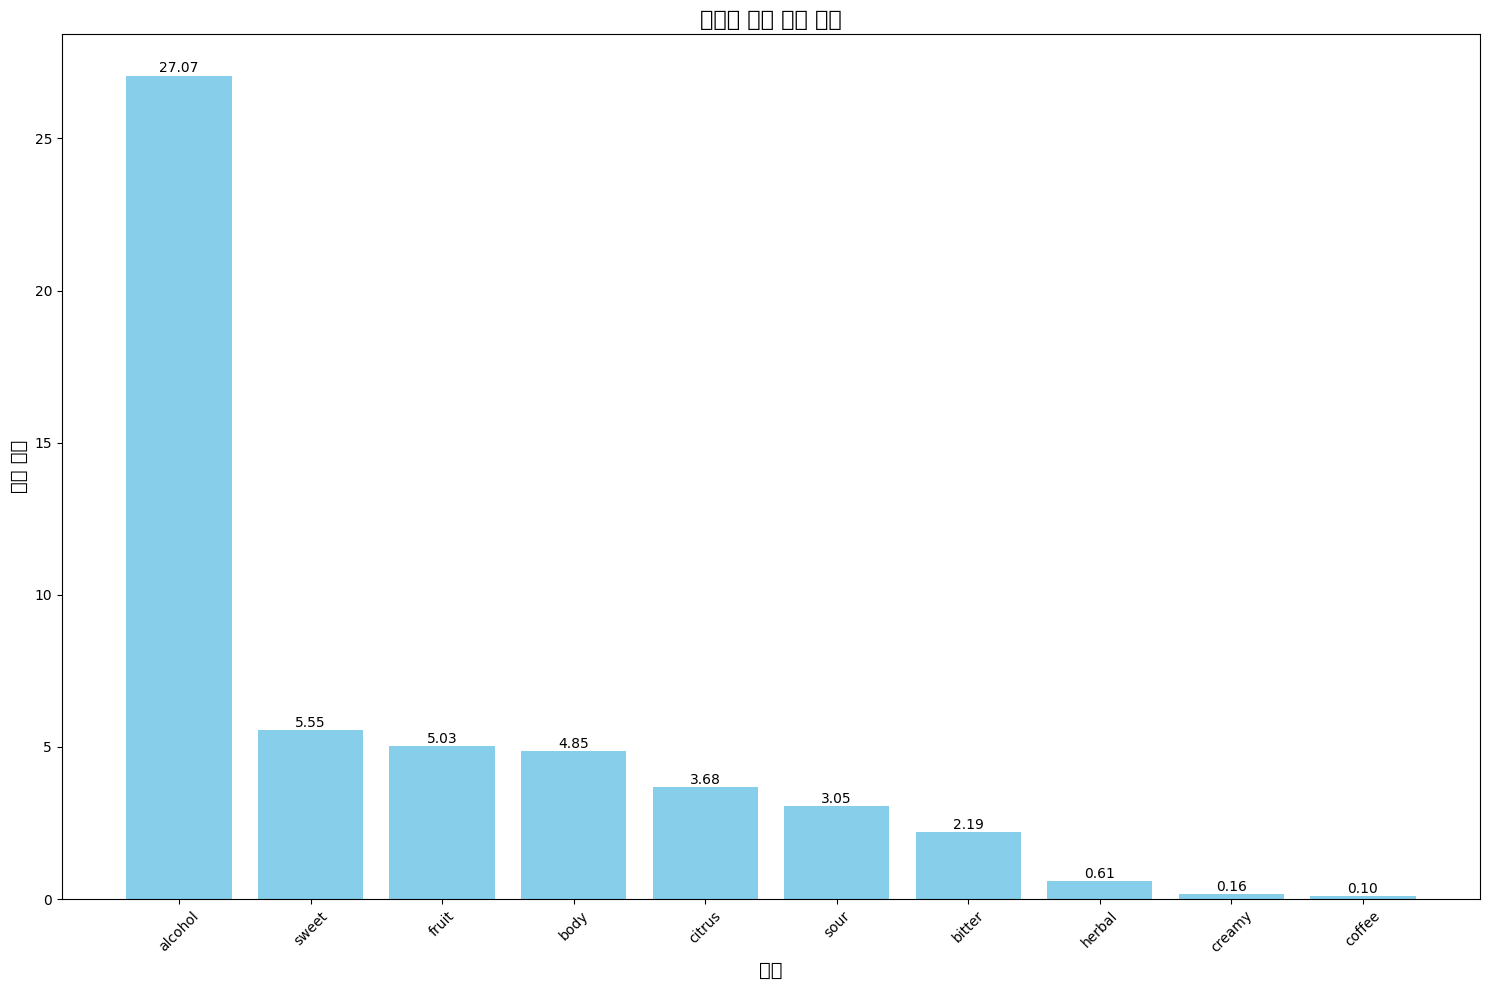

C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:52: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:52: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:52: UserWarning: Glyph 52853 (\N{HANGUL SYLLABLE KAG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:52: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:52: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:52: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppDat

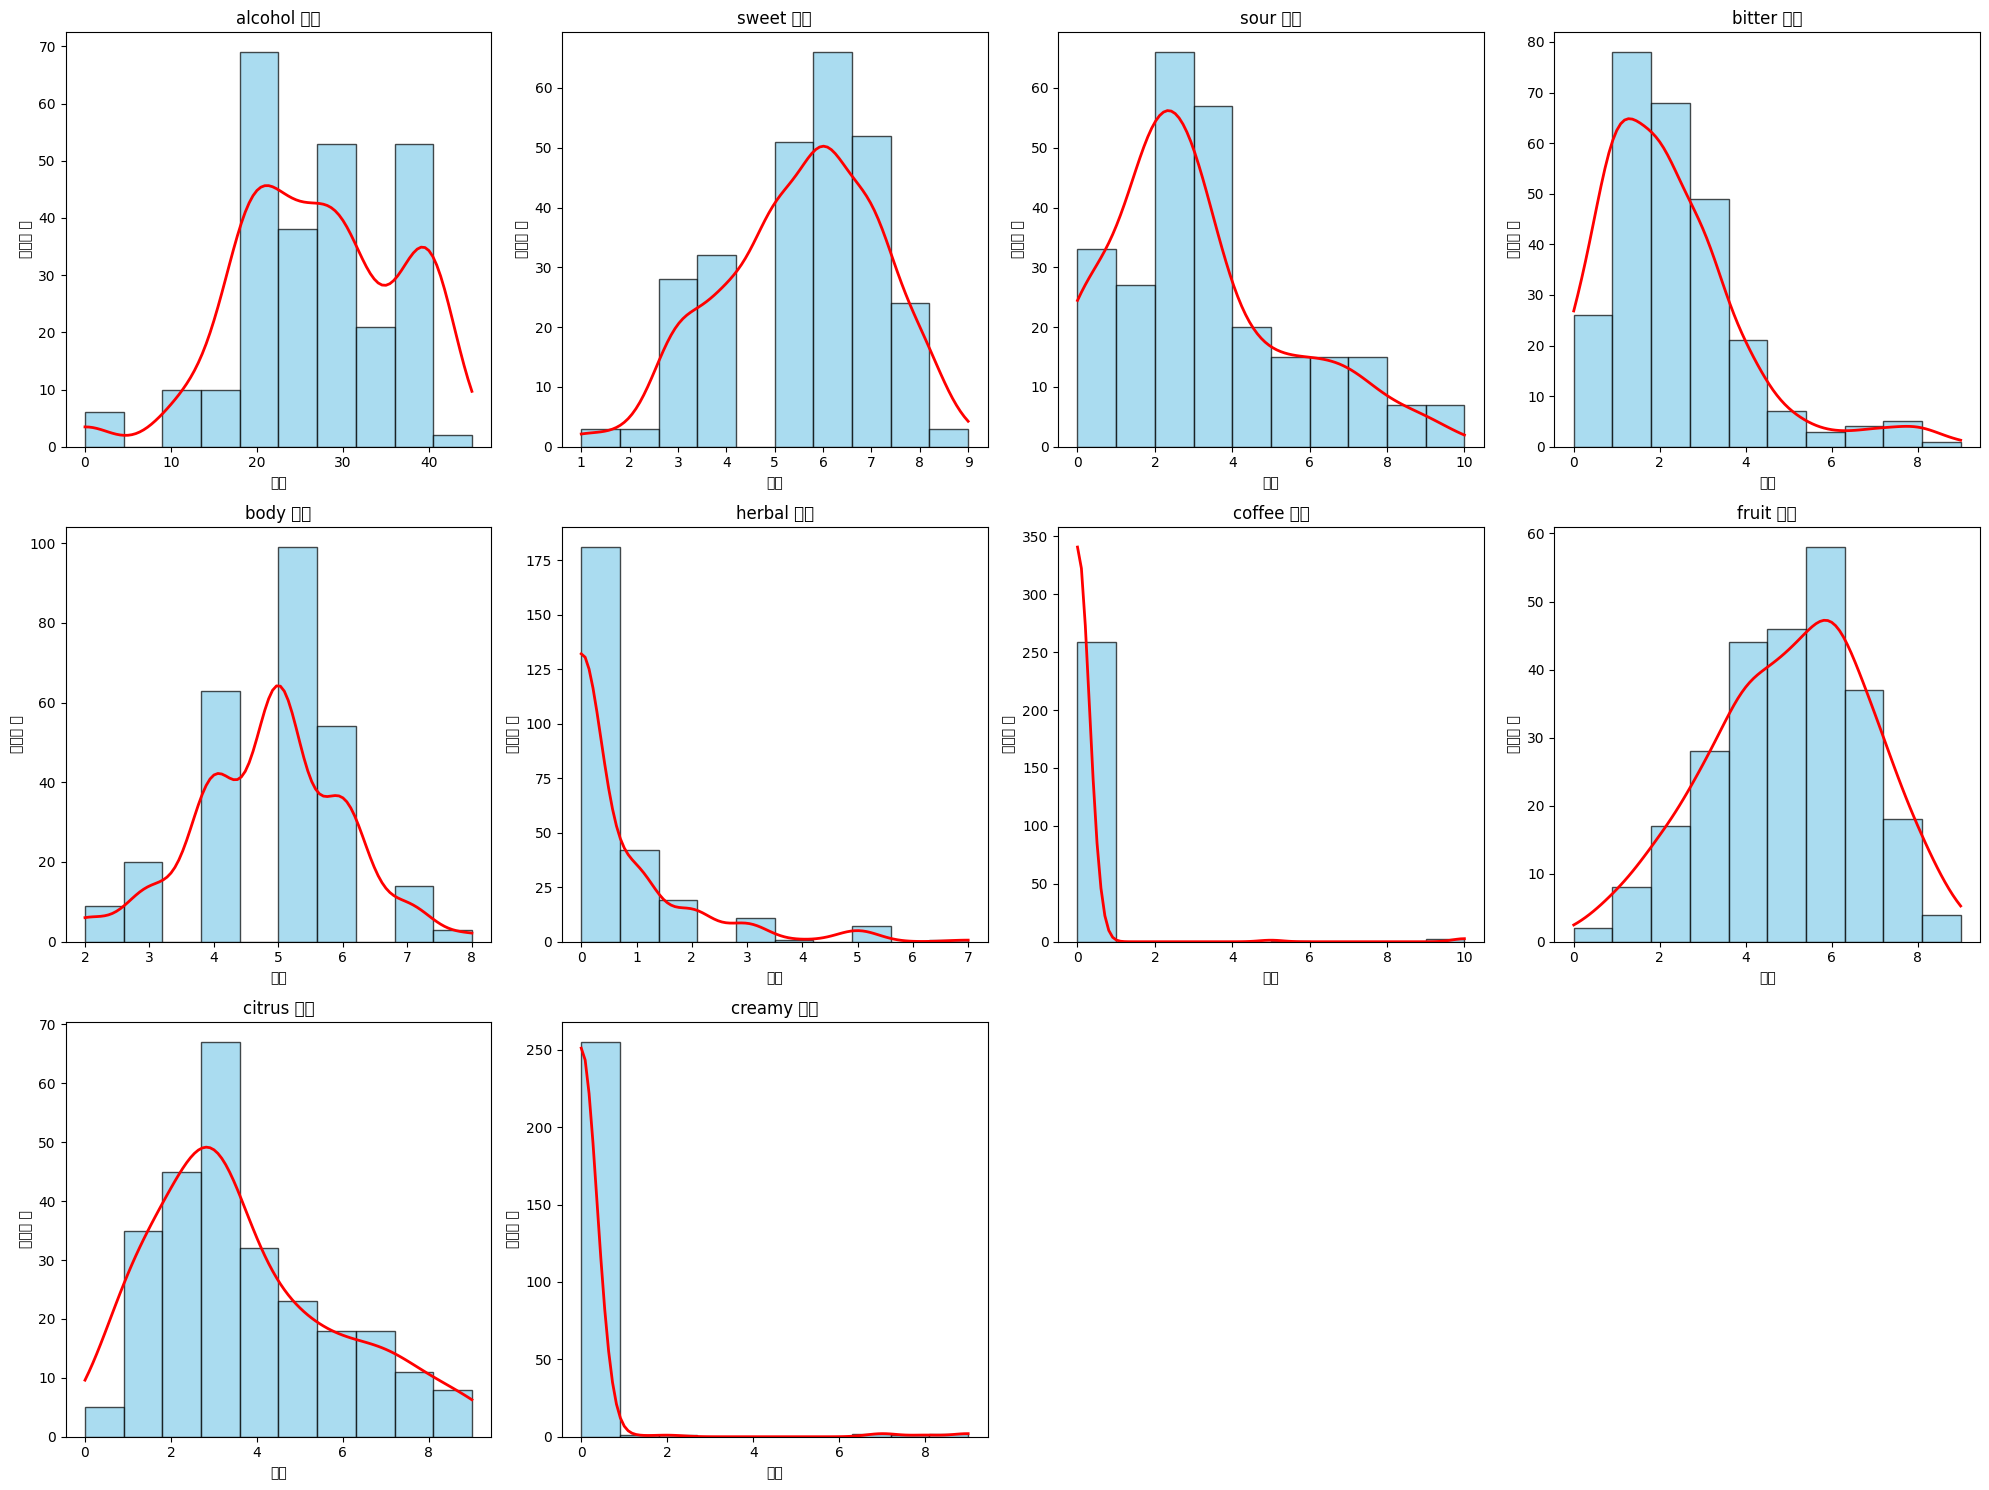

C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:65: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:65: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:65: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:65: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:65: UserWarning: Glyph 52853 (\N{HANGUL SYLLABLE KAG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:65: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  plt.tight_layout()
C:\Users\지원\Ap

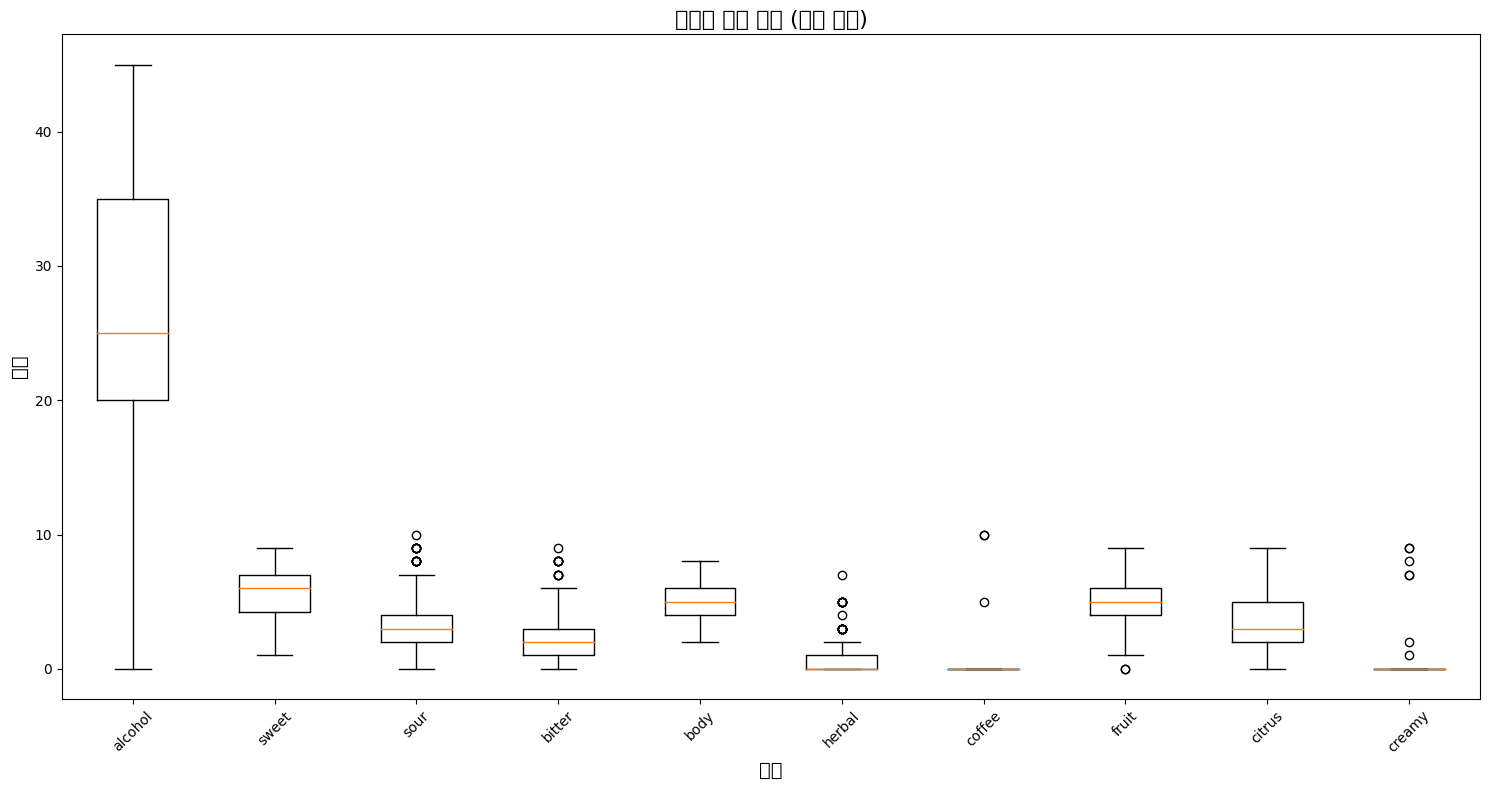

C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:86: UserWarning: Glyph 52853 (\N{HANGUL SYLLABLE KAG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:86: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:86: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:86: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:86: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:86: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  plt.tight_layout()
C:\Users\지원\App

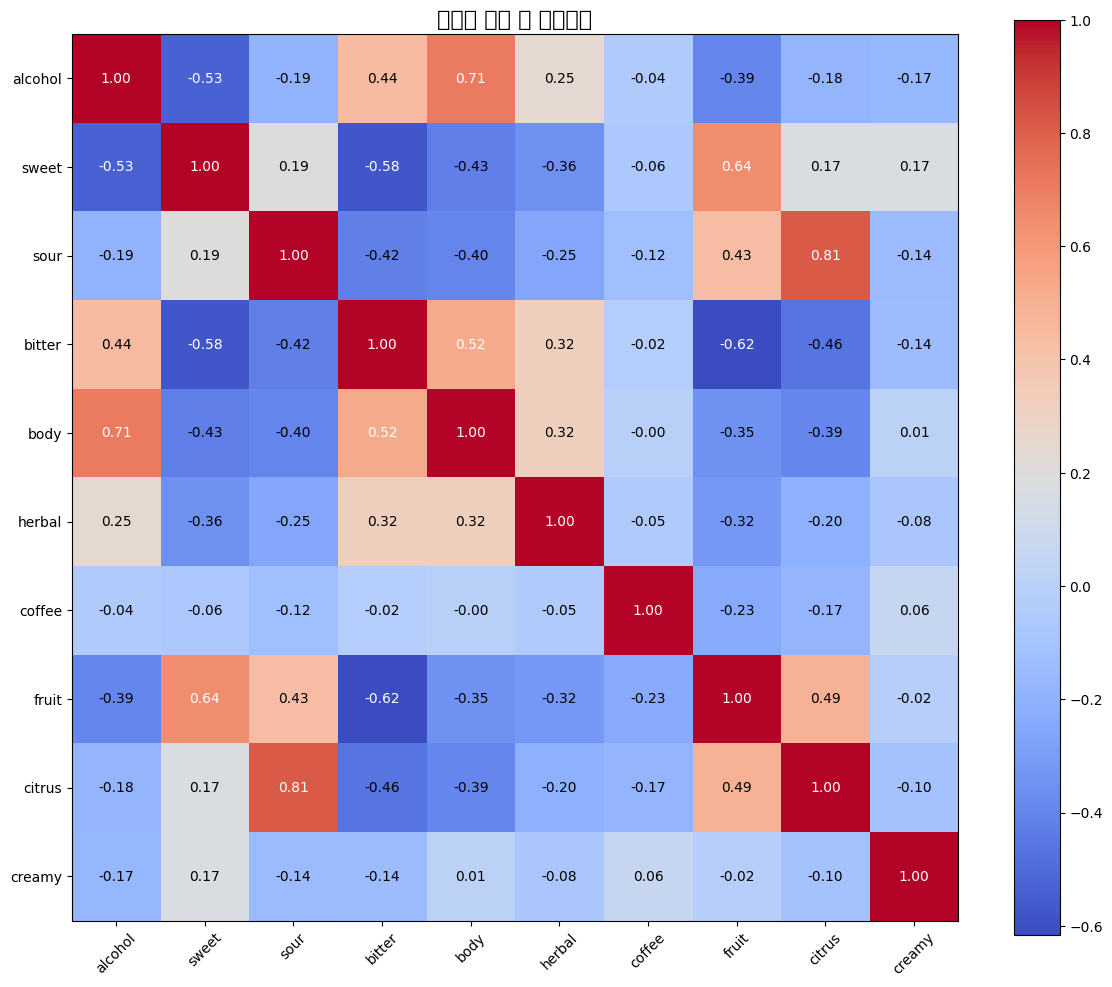

C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:117: UserWarning: Glyph 52853 (\N{HANGUL SYLLABLE KAG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:117: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:117: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:117: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:117: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
C:\Users\지원\AppData\Local\Temp\ipykernel_22832\2590981312.py:117: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from current font.
  plt.tight_layout()
C:\Users\

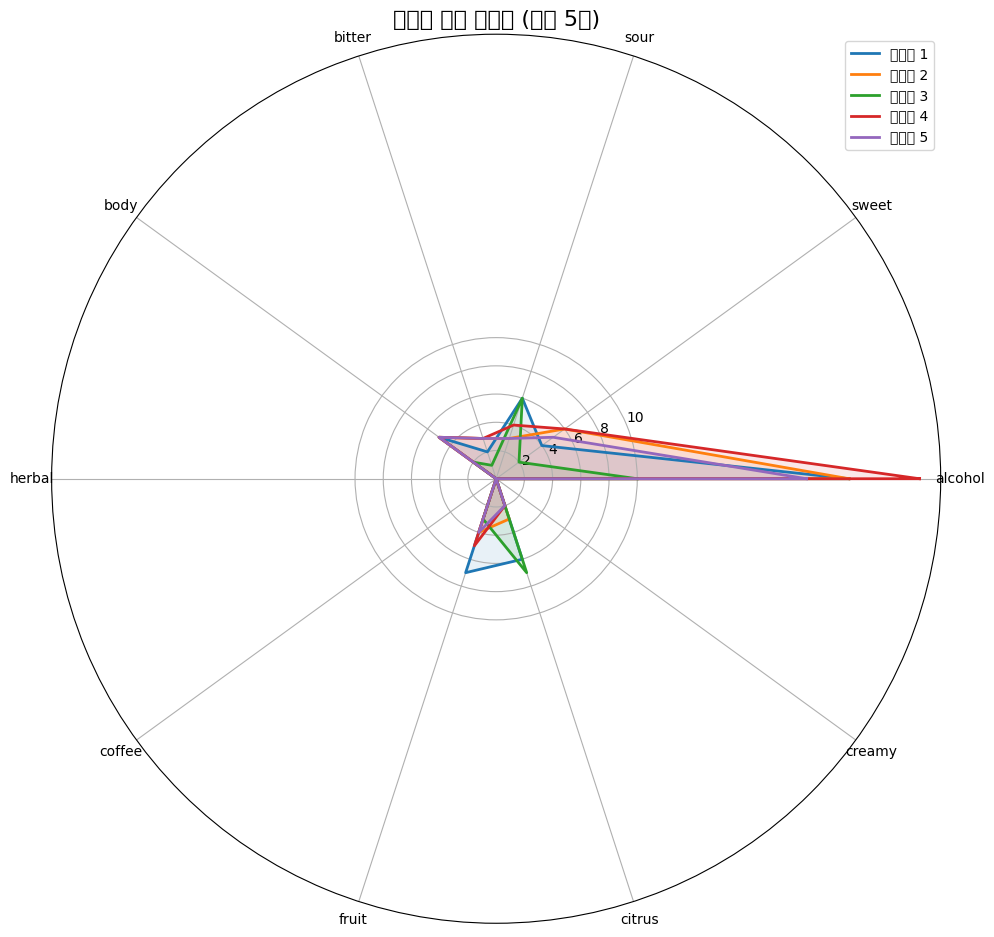

시각화가 완료되었습니다.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# drinks.csv 파일 로드
drink_df = pd.read_csv("drinks.csv")

# 시각화할 특성 목록
features = ['alcohol', 'sweet', 'sour', 'bitter', 'body', 'herbal', 'coffee', 'fruit', 'citrus', 'creamy']

# 1. 각 특성의 분포를 막대 그래프로 표시
plt.figure(figsize=(15, 10))

# 특성별 평균값 계산
mean_values = drink_df[features].mean().sort_values(ascending=False)

# 막대 그래프 그리기
bars = plt.bar(mean_values.index, mean_values.values, color='skyblue')
plt.title('칵테일 특성 평균 분포', fontsize=16)
plt.xlabel('특성', fontsize=14)
plt.ylabel('평균 점수', fontsize=14)
plt.xticks(rotation=45)

# 막대 위에 값 표시
for bar, value in zip(bars, mean_values.values):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.1, f'{value:.2f}', 
             ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('cocktail_features_avg.png')
plt.show()

# 2. 각 특성 분포의 히스토그램
plt.figure(figsize=(20, 15))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 4, i)
    
    # 히스토그램 그리기
    n, bins, patches = plt.hist(drink_df[feature], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    
    # KDE 곡선 그리기 (matplotlib로만)
    from scipy.stats import gaussian_kde
    x = np.linspace(min(drink_df[feature]), max(drink_df[feature]), 100)
    kde = gaussian_kde(drink_df[feature])
    plt.plot(x, kde(x) * len(drink_df[feature]) * (bins[1] - bins[0]), 'r-', linewidth=2)
    
    plt.title(f'{feature} 분포')
    plt.xlabel('점수')
    plt.ylabel('칵테일 수')

plt.tight_layout()
plt.savefig('cocktail_features_histogram.png')
plt.show()

# 3. 특성들의 박스 플롯
plt.figure(figsize=(15, 8))

# 박스플롯 그리기
plt.boxplot(drink_df[features].values, labels=features)
plt.title('칵테일 특성 분포 (박스 플롯)', fontsize=16)
plt.xlabel('특성', fontsize=14)
plt.ylabel('점수', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('cocktail_features_boxplot.png')
plt.show()

# 4. 히트맵으로 특성 간의 상관관계 표시
plt.figure(figsize=(12, 10))
correlation = drink_df[features].corr()

# 히트맵 그리기
im = plt.imshow(correlation, cmap='coolwarm')
plt.colorbar(im)

# 상관계수 표시
for i in range(len(correlation)):
    for j in range(len(correlation)):
        text = plt.text(j, i, f'{correlation.iloc[i, j]:.2f}',
                       ha='center', va='center', color='white' if abs(correlation.iloc[i, j]) > 0.5 else 'black')

plt.xticks(range(len(correlation)), correlation.columns, rotation=45)
plt.yticks(range(len(correlation)), correlation.index)
plt.title('칵테일 특성 간 상관관계', fontsize=16)
plt.tight_layout()
plt.savefig('cocktail_features_correlation.png')
plt.show()

# 5. 레이더 차트로 특성 프로필 시각화 (상위 5개 칵테일 예시)
def make_radar_chart(df, features, n_samples=5):
    # 데이터 준비
    samples = df.sample(n_samples) if len(df) > n_samples else df
    
    # 각도 계산
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]  # 닫힌 다각형을 위해 처음 각도 추가
    
    # 그래프 설정
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # 각 샘플에 대한 레이더 차트 그리기
    for i, (idx, row) in enumerate(samples.iterrows()):
        values = row[features].values.tolist()
        values += values[:1]  # 닫힌 다각형을 위해 처음 값 추가
        
        ax.plot(angles, values, linewidth=2, label=f'칵테일 {i+1}')
        ax.fill(angles, values, alpha=0.1)
    
    # 그래프 꾸미기
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features)
    ax.set_yticks([2, 4, 6, 8, 10])
    ax.set_title('칵테일 특성 프로필 (랜덤 5개)', fontsize=16)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig('cocktail_radar_chart.png')
    plt.show()

make_radar_chart(drink_df, features)

print("시각화가 완료되었습니다.")